https://minerandodados.com.br/analise-e-agrupamento-de-clientes-com-machine-learning-k-means/

## Importando as Libs

In [295]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import date
import re 

In [296]:
df = pd.read_csv("https://raw.githubusercontent.com/diogenesjusto/FIAP/master/Gradua%C3%A7%C3%A3o/2021/S2/20210914/db_Exercicio_RFM.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,CUSTOMER_ID,STORE_ID,PRODUCT_ID,AMOUNT,DATE
0,95595791691,409,196282,8.980,2020-01-01 00:14:41 UTC
1,8814812624,62,136956,0.000,2020-01-01 00:10:16 UTC
2,38552620634,408,329,9.980,2020-01-01 00:08:29 UTC
3,11561694614,405,104089,7.990,2020-01-01 00:06:10 UTC
4,1216506698,62,196180,11.960,2020-01-01 00:05:30 UTC


## Iniciando a fase Exploratória 

In [297]:
#Retirar notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df.describe()

,CUSTOMER_ID,STORE_ID,PRODUCT_ID,AMOUNT
count,92294.000,92294.000,92294.000,92294.000
mean,45071670956583.531,308.693,161092.190,14.412
std,530758653619370.312,156.865,49956.383,24.769
min,191.000,56.000,307.000,0.000
25%,4843798878.000,72.000,138236.000,4.590
50%,10157908607.000,407.000,188845.000,8.900
75%,50836412672.000,410.000,196055.000,15.900
max,6298976533617329.000,417.000,198458.000,1548.030


In [298]:
df.dtypes

CUSTOMER_ID      int64
STORE_ID         int64
PRODUCT_ID       int64
AMOUNT         float64
DATE            object
dtype: object

In [299]:
df.shape

(92294, 5)

In [300]:
df.isnull().sum()

CUSTOMER_ID    0
STORE_ID       0
PRODUCT_ID     0
AMOUNT         0
DATE           0
dtype: int64

In [301]:
# CRIANDO DF_AUX
df_aux = df[['DATE','STORE_ID','PRODUCT_ID','AMOUNT']]
# Ajustando dtypes
df_aux['DATE'] = df_aux['DATE'].astype('datetime64')
df_aux['STORE_ID'] = df_aux['STORE_ID'].astype('int64')
df_aux['PRODUCT_ID'] = df_aux['PRODUCT_ID'].astype('int64')
df_aux['AMOUNT'] = df_aux['AMOUNT'].astype('float64')
# Feature Eng
#df_aux['MES'] = df_aux['DATE'].dt.month
#df_aux['ANO'] = df_aux['DATE'].dt.year
df_aux['MES'] =  pd.to_datetime([str(x)[:7]+'-01' for x in df_aux['DATE']])
df_aux['ANO'] =  pd.to_datetime([str(x)[:4]+'-01-01' for x in df_aux['DATE']])
df_aux.index = df_aux['DATE']
del df_aux['DATE']
df_aux

<ipython-input-301-61013332d520>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['DATE'] = df_aux['DATE'].astype('datetime64')
<ipython-input-301-61013332d520>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['STORE_ID'] = df_aux['STORE_ID'].astype('int64')
<ipython-input-301-61013332d520>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,STORE_ID,PRODUCT_ID,AMOUNT,MES,ANO
DATE,,,,,
2020-01-01 00:14:41,409,196282,8.980,2020-01-01,2020-01-01
2020-01-01 00:10:16,62,136956,0.000,2020-01-01,2020-01-01
2020-01-01 00:08:29,408,329,9.980,2020-01-01,2020-01-01
2020-01-01 00:06:10,405,104089,7.990,2020-01-01,2020-01-01
2020-01-01 00:05:30,62,196180,11.960,2020-01-01,2020-01-01
...,...,...,...,...,...
2019-11-08 10:29:32,417,160178,2.150,2019-11-01,2019-01-01
2019-11-08 10:29:22,405,194991,2.990,2019-11-01,2019-01-01
2019-11-08 10:27:06,415,185621,4.300,2019-11-01,2019-01-01


## Gastos ao longo do tempo 

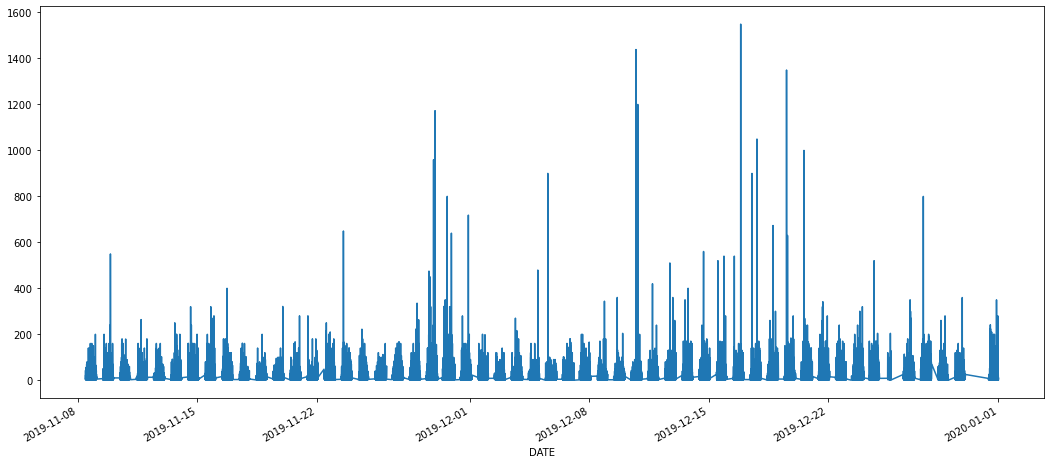

In [302]:
df_aux['AMOUNT'].plot(figsize=(18,8));

## Faturamento mensal

In [313]:
# df_mes
df_mes = df_aux[['MES','AMOUNT']].copy()
df_mes = df_mes.groupby('MES').sum().reset_index()
df_mes.index = df_mes['MES']
del df_mes['MES']
df_mes

,AMOUNT
MES,
2019-11-01,529449.520
2019-12-01,800646.870
2020-01-01,66.710


FATURAMENTO MENSAL


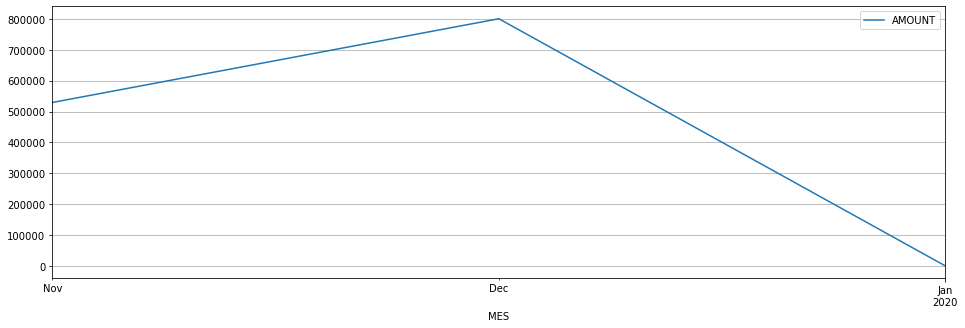

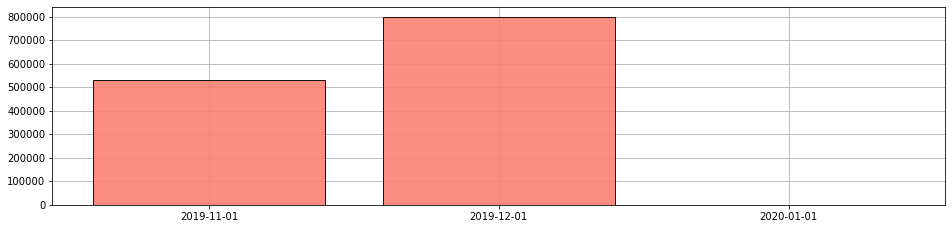

In [314]:
print('FATURAMENTO MENSAL')
df_mes.plot(figsize=(16,5));
plt.grid(True)
plt.figure(figsize=(16,8))
plt.subplot(2,1,2)

df_mes = df_mes.reset_index()
df_mes['MES'] = df_mes['MES'].astype(str)
plt.bar(df_mes['MES'],df_mes['AMOUNT'],data=df_mes, edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
#plt.title("Produtos que mais faturaram (Top 7)")
#plt.xlabel('PRODUCT_ID')
plt.show()

## Faturamento Anual (Gráfico Enviesado por baixa quantidade de dados em 2020)

In [305]:
# df_ano
df_ano = df_aux[['ANO','AMOUNT']].copy()
df_ano = df_ano.groupby('ANO').sum().reset_index()
df_ano.index = df_ano['ANO']
del df_ano['ANO']

FATURAMENTO ANUAL


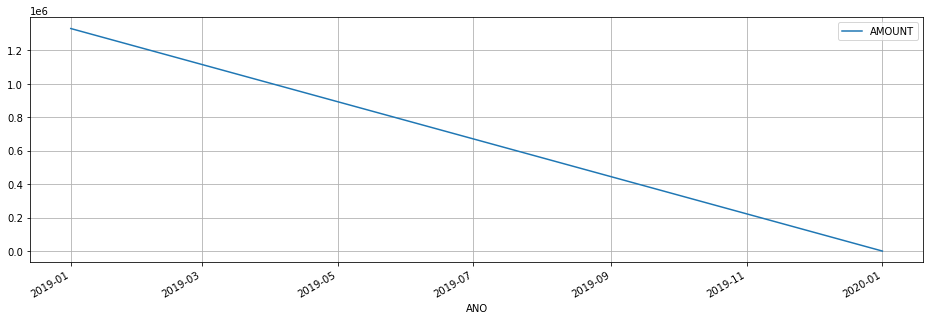

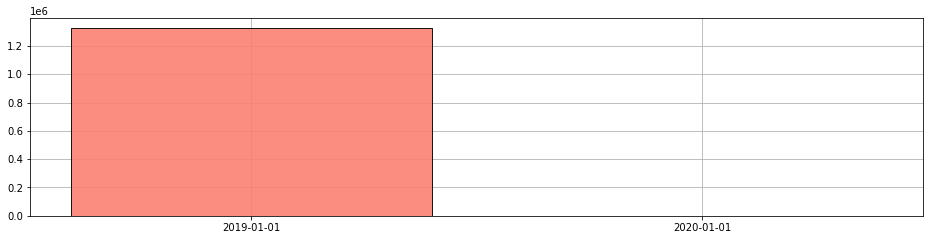

In [317]:
# df_ano
df_ano = df_aux[['ANO','AMOUNT']].copy()
df_ano = df_ano.groupby('ANO').sum().reset_index()
df_ano.index = df_ano['ANO']
del df_ano['ANO']

print('FATURAMENTO ANUAL')

df_ano.plot(figsize=(16,5));
plt.grid(True)
plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 

df_ano = df_ano.reset_index()
df_ano['ANO'] = df_ano['ANO'].astype(str)
plt.bar(df_ano['ANO'],df_ano['AMOUNT'],data=df_ano, edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.show()

## Faturmento de Produto e Estoque

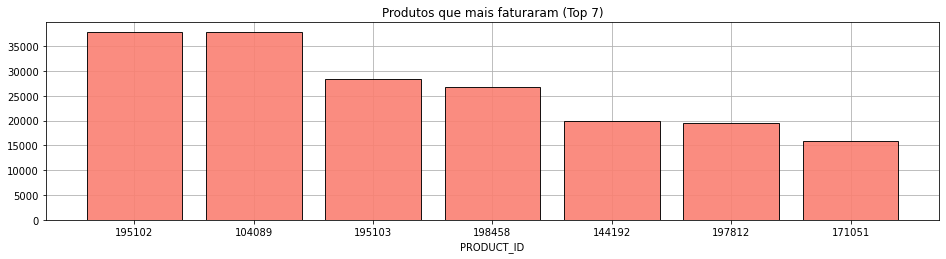

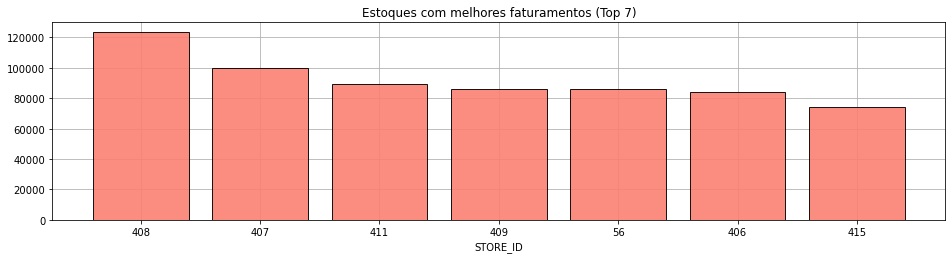

In [315]:
# df_mes_product
df_mes_product = df_aux[['MES','PRODUCT_ID','AMOUNT']].copy()
df_mes_product = df_mes_product.groupby(['MES','PRODUCT_ID']).sum().reset_index()
df_mes_product.index = [i for i in range(len(df_mes_product))]
df_mes_product['PRODUCT_ID'] = df_mes_product['PRODUCT_ID'].astype(str)
del df_mes_product['MES']

df_sorted_desc = df_mes_product.groupby('PRODUCT_ID').sum().reset_index().sort_values('AMOUNT',ascending=False).iloc[:7]

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
plt.bar(df_sorted_desc['PRODUCT_ID'],df_sorted_desc['AMOUNT'],data=df_sorted_desc, edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Produtos que mais faturaram (Top 7)")
plt.xlabel('PRODUCT_ID')
plt.show()


# df_mes_product
df_mes_store = df_aux[['MES','STORE_ID','AMOUNT']].copy()
df_mes_store = df_mes_store.groupby(['MES','STORE_ID']).sum().reset_index()
df_mes_store.index = [i for i in range(len(df_mes_store))]
df_mes_store['STORE_ID'] = df_mes_store['STORE_ID'].astype(str)
del df_mes_store['MES']

df_sorted_desc = df_mes_store.groupby('STORE_ID').sum().reset_index().sort_values('AMOUNT',ascending=False).iloc[:7]

plt.figure(figsize=(16,8))
plt.subplot(2,1,2) 
plt.bar(df_sorted_desc['STORE_ID'],df_sorted_desc['AMOUNT'],data=df_sorted_desc, edgecolor="black",linewidth = 1, color = 'salmon', zorder = 3, alpha = 0.9)
plt.grid(True, zorder = 0)
plt.title("Estoques com melhores faturamentos (Top 7)")
plt.xlabel('STORE_ID')
plt.show()

print('\n\n')

## Iniciação do tratamento das Features

<br>


#### 1- Criação das Features RFV 

<br>

Definição RFV:  RFV (ou RFM em algumas literaturas) entende-se como Recência, Freqüência e Valor monetário do cliente. Recência como uma medida de quanto tempo se passou desde a última transação com a empresa. Freqüência como uma medida de quão freqüente um cliente efetua transações. E Valor Monetário como o gasto médio feito por transação. Estratégias baseadas em RFV buscam métricas ou regras para avaliar o comportamento e valor do cliente para a empresa.

<br>
<br>

In [59]:
df_filter = df.copy()

In [60]:
df_filter.columns

Index(['CUSTOMER_ID', 'STORE_ID', 'PRODUCT_ID', 'AMOUNT', 'DATE'], dtype='object')

### Criação da Feature "Recência"

In [61]:
# criando Feature "Recência" (tempo se passou desde a última transação com a empresa)
df_filter["DATE"] = pd.to_datetime(df_filter["DATE"], dayfirst=True).dt.date
df_filter["DATE"]

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
92289    2019-08-11
92290    2019-08-11
92291    2019-08-11
92292    2019-08-11
92293    2019-08-11
Name: DATE, Length: 92294, dtype: object

In [63]:
df_filter["Recencia_dias"] = (date.today() - df_filter["DATE"])

def remove_string(x):
    
    # Lib "RE", para dar replace em padrões textuais
    string = str(x)
    str_clean = re.sub("days", "", string)

    return str_clean


df_filter["Recencia_dias"] = df_filter["Recencia_dias"].astype(str)
df_filter["Recencia_dias"] = df_filter["Recencia_dias"].apply(lambda x: remove_string(x))
df_filter["Recencia_dias"] = df_filter["Recencia_dias"].astype(np.int64)

In [70]:
def remove_space(x):
    string = str(x)
    string = string.strip()
    return string

In [71]:
df_filter["DATE"] = df_filter["DATE"].apply(lambda x: remove_space(x))

In [72]:
df_filter["DATE"]

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
92289    2019-08-11
92290    2019-08-11
92291    2019-08-11
92292    2019-08-11
92293    2019-08-11
Name: DATE, Length: 92294, dtype: object

### Criação da Feature "Frequência"

In [73]:
# criando feature "frequência" 
df_filter.rename(columns={"DATE":"Frequencia"}, inplace=True)

In [74]:
df_filter.columns

Index(['CUSTOMER_ID', 'STORE_ID', 'PRODUCT_ID', 'AMOUNT', 'Frequencia',
       'Recencia_dias'],
      dtype='object')

In [75]:
df_filter_grouped = df_filter.groupby(by = ['CUSTOMER_ID','STORE_ID']).agg({'AMOUNT': 'sum', 'Recencia_dias': 'sum'}).reset_index().sort_values(by = ['AMOUNT'],ascending = False)
df_filter_grouped

,CUSTOMER_ID,STORE_ID,AMOUNT,Recencia_dias
10869,4044160635,56,3953.030,12760
24956,8798896679,409,2210.150,128577
46882,70251037649,408,1887.300,1987
49302,80044514620,415,1828.940,22588
15365,5421239675,71,1755.200,2182
...,...,...,...,...
43667,57495106620,56,0.000,668
43745,57765561634,57,0.000,665
7221,3006105648,58,0.000,627
43855,58161287600,73,0.000,633


In [128]:
df_filter_grouped = df_filter.groupby(by = ['CUSTOMER_ID','STORE_ID', 'Frequencia']).agg({'AMOUNT': 'sum', 'Recencia_dias': 'count'}).reset_index().sort_values(by = ['Recencia_dias'],ascending = False)
df_filter_grouped

,CUSTOMER_ID,STORE_ID,Frequencia,AMOUNT,Recencia_dias
43812,14094142649,56,2019-12-23,665.190,24
23300,5988542662,414,2019-12-12,559.160,22
14987,4044160635,56,2019-12-18,3953.030,20
33536,8798896679,409,2019-01-12,268.160,17
33571,8798898612,409,2019-12-20,255.980,16
...,...,...,...,...,...
27413,7003575647,66,2019-12-24,8.380,1
27414,7003575647,410,2019-05-12,19.900,1
27415,7003733650,406,2019-11-28,7.890,1
27416,7003956608,417,2019-12-20,39.900,1


### Criação da Feature "Valor"

In [129]:
# criando feature de "valor"

def value_function(row):

  
    if row["AMOUNT"] >= 0 and row["AMOUNT"] <= 50:
          return 0
            
    if row["AMOUNT"] >= 51 and row["AMOUNT"] <= 100:
          return 1 
            
    if row["AMOUNT"] >= 101 and row["AMOUNT"] <= 200:
          return 2 
            
    if row["AMOUNT"] >= 201 and row["AMOUNT"] <= 300:
          return 3 
            
    if row["AMOUNT"] >= 301 and row["AMOUNT"] <= 400:
          return 4 
    
    if row["AMOUNT"] >= 401:
          return 5 

    else:
        return 0

    return value 




# criando feature Valor 
df_filter_grouped["Valor"] = df_filter_grouped.apply(lambda row: value_function(row), axis=1)
#df_filter["Valor"].replace(np.nan, 0, inplace=True)

In [130]:
df_filter_grouped["Valor"].value_counts()

0    70737
1     3040
2      809
3      157
5       51
4       42
Name: Valor, dtype: int64

## Jogando as Features que serão utilizadas para um novo DataFrame

In [169]:
df = df_filter_grouped[["CUSTOMER_ID","Frequencia", "Recencia_dias", 'Valor']]

In [170]:
df.head()

,CUSTOMER_ID,Frequencia,Recencia_dias,Valor
43812,14094142649,2019-12-23,24,5
23300,5988542662,2019-12-12,22,5
14987,4044160635,2019-12-18,20,5
33536,8798896679,2019-01-12,17,3
33571,8798898612,2019-12-20,16,3


In [171]:
df.dtypes

CUSTOMER_ID       int64
Frequencia       object
Recencia_dias     int64
Valor             int64
dtype: object

In [172]:
df['Frequencia'] = pd.to_datetime(df['Frequencia'])

<ipython-input-172-82d0b5fc527a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequencia'] = pd.to_datetime(df['Frequencia'])


In [173]:
df['Frequencia_ano'] = df['Frequencia'].apply(lambda time: time.weekofyear)

<ipython-input-173-329acf9ef13a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequencia_ano'] = df['Frequencia'].apply(lambda time: time.weekofyear)


In [174]:
df['Frequencia_ano'].value_counts()

51    10229
48     9955
52     8831
46     8604
47     8265
50     6987
41     2768
37     2697
28     2567
2      2130
24     2011
33     1957
1      1775
11     1267
19     1261
15     1250
32     1175
7      1107
Name: Frequencia_ano, dtype: int64

## Iniciando o tratamento/processamento das colunas 

In [272]:
df.columns

Index(['CUSTOMER_ID', 'Frequencia', 'Recencia_dias', 'Valor',
       'Frequencia_ano'],
      dtype='object')

In [284]:
X = df.drop(columns = ['CUSTOMER_ID', 'Frequencia', 'Valor'])

X = np.array(X)

In [285]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

# Iniciando a modelagem do K-Means

### Pegando o melhor K com o método Elbow

In [286]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X_train)
    inertia.append(algorithm.inertia_)

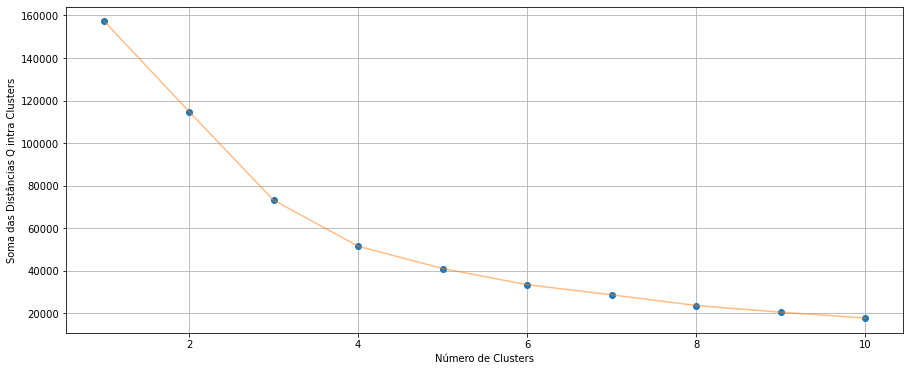

In [287]:
# Para decidir o melhor K, é necessário traçar reta na diagonal, do primeiro 
# até o último K, o que estiver mais longe dela, será o K mais equilibrado
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.grid(True)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

In [277]:
label = algorithm.predict(X)
label

ValueError: X has 2 features, but KMeans is expecting 3 features as input.

In [ ]:
np.bincount(label)

In [288]:
algorithm = KMeans(n_clusters = 4)
algorithm.fit(X)

KMeans(n_clusters=4)

In [289]:
label = algorithm.predict(X)
label

array([0, 0, 0, ..., 0, 0, 0])

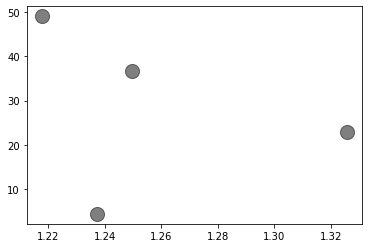

In [290]:
centers = algorithm.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [269]:
X.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [252]:
len(df['CUSTOMER_ID'])

74836

In [253]:
len(label)

74836

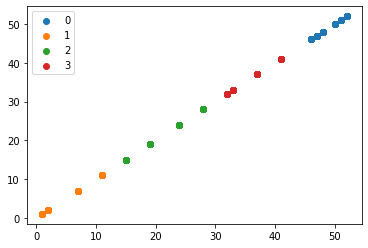

In [291]:
#Getting unique labels
u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(X[label == i , 1] , X[label == i , 1] , label = i)
plt.legend()
plt.show()

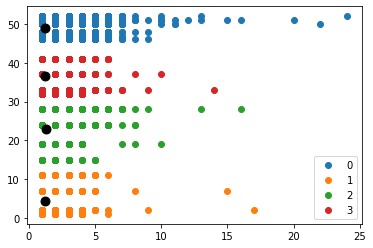

In [292]:
#Getting the Centroids
centroids = algorithm.cluster_centers_
u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

<br>
<br>
<hr>
<br>
<br>
<br>